In [1]:
!pip install sentence_transformers

In [2]:
import json
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, losses, util
from torch.utils.data import random_split
from sklearn.metrics import f1_score , precision_score ,recall_score
from sentence_transformers.util import cos_sim




## Read and understand data

In [3]:

with open('data/dataset_big_patent_v1.json','r') as f:
    data = json.load(f)



In [4]:
def word_count_statistic(key:str):
    ## count the number of queries
    num_sample = len(data)
    print("Number of {}: {}".format(key, num_sample))

    # Quantitative analysis: Length of each query
    lengths = [len(item[key].split()) for item in data]
    average_count= sum(lengths) / num_sample
    max_count = max(lengths)
    print("Average number of words in {} : {}".format(key ,average_count))
    print("Max number of word in {} : {}".format(key,max_count))




In [5]:
key_words= ['query','pos','negative']
for k in key_words:
    word_count_statistic(k)
    print('')


Number of query: 499
Average number of words in query : 18.100200400801604
Max number of word in query : 33

Number of pos: 499
Average number of words in pos : 3004.835671342685
Max number of word in pos : 3078

Number of negative: 499
Average number of words in negative : 267.5090180360721
Max number of word in negative : 1707



In [6]:
### Check duplicate query to avoid overfiting
queries = [item['query'] for item in data]
duplicate_queries = len(queries) - len(set(queries))
if duplicate_queries== 0:
    print("No duplicate")



No duplicate


In [7]:
### check missing data
# Check if all items have 'query', 'pos', and 'negative' keys
all_keys_present = all(
    'query' in item and 'pos' in item and 'negative' in item
    for item in data
)
if all_keys_present:
    print("All items have 'query', 'pos', and 'negative' keys.")
else:
    print("Some items are missing 'query', 'pos', or 'negative' keys.")

All items have 'query', 'pos', and 'negative' keys.


In [8]:
### Not a lot data for finetuning , risk of overfitting
### Positive answer are more long than negative
### Presence oh technical sign in the document like the chimique formular
### A lot of fiversity in data
### Data is about some prompt with a postive and negative answer. we want to learn the good embedding for LLM -RAg this will help model to retrieve the good context in Vector DB


In [9]:
dataframe = pd.DataFrame.from_dict(data)

dataframe

,query,negative,pos
0,What are the key advantages and applications o...,The present technology introduces an innovativ...,RELATED APPLICATIONS This application claims t...
1,How does a magnetic energy harvester operate w...,The advanced energy accumulation equipment bei...,RELATED APPLICATIONS This application claims t...
2,How does an energy harvester operate without a...,The invention relates to the design and utilit...,RELATED APPLICATIONS This application claims t...
3,How can buffer blocks for ruminant animals be ...,The innovative technique pertains to mineral s...,BACKGROUND OF THE INVENTION I. Field of the In...
4,What advancements does the described patent pr...,The current text discusses a novel mechanical ...,RELATED APPLICATION The present application cl...
...,...,...,...
494,What is the role of Onjisaponin B in the treat...,Delineation of the effect of a botanical enhan...,CROSS-REFERENCE TO RELATED APPLICATION [0001] ...
495,What is the mechanism by which Onjisaponin B e...,This invention pertains to a unique compound f...,CROSS-REFERENCE TO RELATED APPLICATION [0001] ...
496,What are the advantages of the improved dental...,The present innovations focus on an enhanced s...,RELATED APPLICATIONS [0001] This application i...
497,What are the benefits and mechanisms of a nove...,The technology relates to an innovation in hem...,FIELD [0001] The invention refers to a ventric...


## Finetuning Step

In [10]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:

# Load pre-trained Sentence Transformer model
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", trust_remote_code=True).to(device)

# Define the size of the validation set
val_size = 0.2  # 20% of the dataset will be used for validation
# Prepare training data (query, positive sample, negative sample triplets)
queries = dataframe['query'].to_list()
positive_samples = dataframe['pos'].to_list()
negative_samples = dataframe['negative'].to_list()




In [22]:
# Define a custom dataset class
class TripletDataset(Dataset):
    def __init__(self, queries, positive_samples, negative_samples):
        self.queries = queries
        self.positive_samples = positive_samples
        self.negative_samples = negative_samples

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, idx):
        return self.queries[idx], self.positive_samples[idx], self.negative_samples[idx]


In [23]:
dataset = TripletDataset(queries, positive_samples, negative_samples)
# Compute the size of the validation set
val_dataset_size = int(val_size * len(dataset))
train_dataset_size = len(dataset) - val_dataset_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_dataset_size, val_dataset_size])

In [24]:
# Define DataLoader for batching
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [25]:
# Define a TripletLoss object
triplet_loss = losses.TripletLoss(model=model)

In [26]:
# last_1_layer = list(model.state_dict().keys())[-1]
# for name, param in model.named_parameters():
#       if name not in last_10_layer:
#          param.requires_grad = False

In [27]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Define the loss criterion (TripletMarginLoss)
criterion = nn.TripletMarginLoss(margin=1.0)

# Loss without finetuning 

In [29]:

model.eval()
all_predictions = []
all_labels = []
val_losses = []
with torch.no_grad():
    val_loss = 0.0
    for val_batch in val_loader:
        # Unpack batch
        query, positive, negative = val_batch

        #Forward and  Move tensors to device
        query_embeddings = model.encode(query, convert_to_tensor=True).requires_grad_(True).to(device)
        positive_embeddings = model.encode(positive, convert_to_tensor=True).requires_grad_(True).to(device)
        negative_embeddings = model.encode(negative, convert_to_tensor=True).requires_grad_(True).to(device)
        # Compute triplet loss
        val_loss += criterion(query_embeddings, positive_embeddings, negative_embeddings).item()
        # Calculate predictions and labels for precision
        predictions = F.cosine_similarity(query_embeddings, positive_embeddings, dim=1) > F.cosine_similarity(query_embeddings, negative_embeddings, dim=1)
        labels = torch.ones_like(predictions)

    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    valid_recall = recall_score(all_labels, all_predictions)

    # Average validation loss
    val_loss /= len(val_loader)


# Append validation loss to list
val_losses.append(val_loss)
# Print validation loss
print(f" Validation Loss without finetuning: {val_loss:.4f}, Validation Recall: {valid_recall:.4f}")


 Validation Loss without finetuning: 0.7265, Validation Recall: 0.3333


## Finetuning

Epoch [1/100], Loss: 0.5841
Epoch [1/100], Validation Loss: 0.9625, Validation Recall: 0.3333
Epoch [2/100], Loss: 0.5923
Epoch [3/100], Loss: 0.5959
Epoch [3/100], Validation Loss: 0.6742, Validation Recall: 1.0000
Epoch [4/100], Loss: 0.5989
Epoch [5/100], Loss: 0.5851
Epoch [5/100], Validation Loss: 0.8738, Validation Recall: 0.6667
Epoch [6/100], Loss: 0.5844
Epoch [7/100], Loss: 0.5919
Epoch [7/100], Validation Loss: 0.6595, Validation Recall: 1.0000
Epoch [8/100], Loss: 0.5975
Epoch [9/100], Loss: 0.5821
Epoch [9/100], Validation Loss: 0.9921, Validation Recall: 0.3333
Epoch [10/100], Loss: 0.5953
Epoch [11/100], Loss: 0.5706
Epoch [11/100], Validation Loss: 0.8950, Validation Recall: 0.6667
Epoch [12/100], Loss: 0.5833
Epoch [13/100], Loss: 0.5903
Epoch [13/100], Validation Loss: 0.7567, Validation Recall: 0.6667
Epoch [14/100], Loss: 0.5848
Epoch [15/100], Loss: 0.5948
Epoch [15/100], Validation Loss: 0.5756, Validation Recall: 1.0000
Epoch [16/100], Loss: 0.5913
Epoch [17/100]

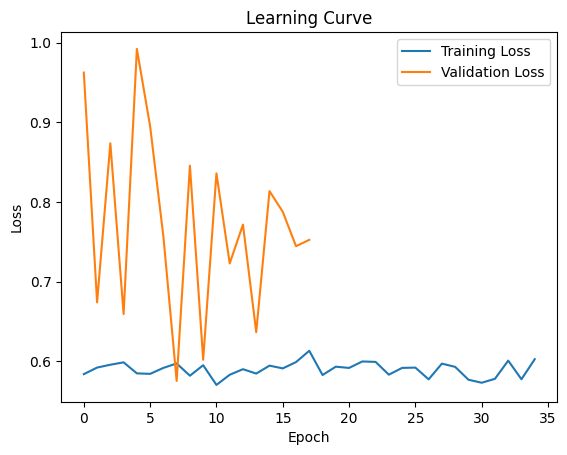

In [30]:

num_epochs = 100  # Define number of epochs
# Define lists to store loss values
train_losses = []
val_losses = []
validation_freq= 2
# Define early stopping parameters
patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
counter = 0

# Fine-tuning loop
for epoch in range(num_epochs):
    # Evaluation metrics
    running_loss = []
    # Training phase
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        # Unpack batch
        query, positive, negative = batch
        # Forward pass
        query_embeddings = model.encode(query, convert_to_tensor=True).requires_grad_(True).to(device)
        positive_embeddings = model.encode(positive, convert_to_tensor=True).requires_grad_(True).to(device)
        negative_embeddings = model.encode(negative, convert_to_tensor=True).requires_grad_(True).to(device)

        # Compute triplet loss
        loss = criterion(query_embeddings, positive_embeddings, negative_embeddings)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Append the loss to running_loss
        running_loss.append(loss.item())

    # Compute the average loss for the epoch
    epoch_loss = np.mean(running_loss)

    # Print the average loss and recall for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Append training loss to list
    train_losses.append(epoch_loss)

    # Early stopping based on validation loss
    if epoch % validation_freq == 0:
        model.eval()
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            val_loss = 0.0
            for val_batch in val_loader:
                # Unpack batch
                query, positive, negative = val_batch

                #Forward and  Move tensors to device
                query_embeddings = model.encode(query, convert_to_tensor=True).requires_grad_(True).to(device)
                positive_embeddings = model.encode(positive, convert_to_tensor=True).requires_grad_(True).to(device)
                negative_embeddings = model.encode(negative, convert_to_tensor=True).requires_grad_(True).to(device)
                # Compute triplet loss
                val_loss += criterion(query_embeddings, positive_embeddings, negative_embeddings).item()
                # Calculate predictions and labels for precision
                predictions = F.cosine_similarity(query_embeddings, positive_embeddings, dim=1) > F.cosine_similarity(query_embeddings, negative_embeddings, dim=1)
                labels = torch.ones_like(predictions)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            valid_recall = recall_score(all_labels, all_predictions)

            # Average validation loss
            val_loss /= len(val_loader)


        # Append validation loss to list
        val_losses.append(val_loss)
        # Print validation loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Recall: {valid_recall:.4f}")

        # Check for improvement in validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"No improvement in validation loss for {patience} epochs. Early stopping...")
                break

# Plot learning curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()
